In [2]:
import numpy as np

# Example: Susceptibility and Bose-Einstein condensation

Recall the density of an ideal gas:

$$
\tilde n (T,\tilde \mu) = \frac{d}{2\pi^2} \int_0^\infty d \tilde k \, \tilde k^2 \, \left[\exp\left\{\sqrt{\tilde{m}^2+\tilde k^2}-\tilde{\mu}\right\} + \eta \right ]^{-1}~,
$$

where $\tilde n \equiv n/T^3$, $\tilde m = m/T$, and $\tilde \mu = \mu / T$.


This density can be computed using numerical integration.
In particular, we can use the Gauss-Laguerre quadrature to compute the integral, given the integration limits $[0,\infty)$ and the asymptotic behavior of the integrand at infinity, $\sim \exp(-\tilde k^2)$.

The susceptibility is defined as a derivative of the density with respect to chemical potential

$$
\chi_2 = \frac{\partial \tilde{n} (\tilde T, \tilde{\mu})}{\partial \tilde \mu}.
$$

For a pion gas ($m = 138~\textrm{MeV}, d = 1, T = 150~\textrm{MeV}$),

1. Compute the susceptibility $\chi_2$ using finite differences at $\tilde{\mu} = 0$, for $\eta = 0$ and $\eta = -1$.
2. Compare the result for $\chi_2$ to the one obtained by numerically integrating the following expression

$$
\chi_2 = \frac{d}{2\pi^2} \int_0^\infty d \tilde k \, \tilde k^2 \, \frac{\exp\left\{\sqrt{\tilde{m}^2+\tilde k^2}-\tilde{\mu}\right\}} {\left[\exp\left\{\sqrt{\tilde{m}^2+\tilde k^2}-\tilde{\mu}\right\} + \eta \right ]^{2}},
$$

3. Compute the susceptibility as a function of $\tilde{\mu}$ in a range $\tilde{\mu} \in (0,\tilde{m})$. What is the behavior of $\chi_2$ as $\tilde{\mu}$ approaches the Bose condensation point, $\tilde{\mu} = \tilde{m}$?

## Preliminaries

We will utilize Gaussian quadratures to compute the integrals.
Let us define (or import) the necessary routines.



In [5]:
import numpy as np

# Generic integration using quadratures
def integrate_quadrature(
    f,   # Function to be integrated 
    quad # A pair of lists (x,w) where x are the integration nodes and w are the weights 
                        ):
    ret = 0.
    n = len(quad[0])
    for k in range(n):
        xk = quad[0][k]
        wk = quad[1][k]
        ret += wk * f(xk)
    return ret

import sympy as sympy
import math

# Nodes and weight for n-point Gauss-Laguerre quadrature
def laguerrexw(n):
  x = sympy.Symbol("x")
  roots = sympy.Poly(sympy.laguerre(n, x)).all_roots()
  x_i = [float(rt.evalf(20)) for rt in roots]
  w_i = [float((rt / ((n + 1) * sympy.laguerre(n + 1, rt)) ** 2).evalf(20)) for rt in roots]
  return x_i, w_i

# Precomute 32-point Gauss-Laguerre quadrature
laguerrexw32 = laguerrexw(32)

Now we define the parameters and the function to be integrated

In [6]:
# Parameters

# Temperature (in MeV)
T = 150

# Chemical potential (in MeV)
mu = 0

# Mass (in MeV)
m = 138

# Degeneracy (1 for single pion)
d = 1

# Quantum statistics (0 for Maxwell-Boltzmann, -1 for Bose-Einstein)
eta = 0

# Integrand (quantum distribution function)
def fThermal(x):
    x = float(x)
    return d * x**2 * np.exp(x) / (2 * np.pi**2) / (np.exp(np.sqrt((m/T)**2 + x**2) - mu/T) + eta)


# Compute the density integral using Gauss-Laguerre quadrature
# n_nodes: number of nodes (default: 32)
def nIntegral(n_nodes = 32):
    quad = laguerrexw32
    if (n_nodes != 32):
        quad = laguerrexw(n_nodes)
    return integrate_quadrature(fThermal, quad)

# Compute the density $n/T^3$ for given temperature and chemical potential
def nT3num(inT, inMu, n_nodes = 32):
    global T, mu
    T = inT
    mu = inMu
    return nIntegral(n_nodes)

from scipy.special import kn

# Analytic expression for the density $n/T^3$ in the Maxwell-Boltzmann limit
def nT3analyt(T, mu, m, d = 1):
    return d * m**2 / (2 * np.pi**2 * T**2) * kn(2,m/T) * np.exp(mu/T)

Test that we reproduce the known result for Maxwell-Boltzmann statistics

In [9]:
eta = 0
T = 150
mu = 0
NGL = 32

print("Maxwell-Boltzmann n/T^3 =", nT3num(T, mu, NGL), "(numerical integration)")
print("Maxwell-Boltzmann n/T^3 =", nT3analyt(T, mu, m, d),"(analytic integration)")

eta = -1
print("Bose-Einstein n/T^3 =", nT3num(T, mu, NGL), "(numerical integration)")


Maxwell-Boltzmann n/T^3 = 0.0847224926254013 (numerical integration)
Maxwell-Boltzmann n/T^3 = 0.08472249379368636 (analytic integration)
Bose-Einstein n/T^3 = 0.09332222578416971 (numerical integration)


## Step 1: Central difference

Let us compute $\chi_2$ as a central difference applied to $n(T, \mu)$:

$$
\chi_2 = \frac{d \tilde n(\tilde T, \tilde \mu)}{d \mu} = \frac{\tilde n(\tilde T, \tilde \mu + \Delta \tilde \mu) - \tilde n(\tilde T, \tilde \mu - \Delta \tilde \mu)}{2 \Delta \tilde \mu}
$$

We will use central difference

In [12]:
def chinumder(T, mu, dmu, NGL = 32):
    # mu - chemical potential
    # dmu - step size in dimensionless mu for numerical derivative
    # eps - accuracy goal for numerical integration
    
    # Central difference
    # chi ~ T * (nT3(mu + dmu) - nT3(mu - dmu)) / (2 * dmu)
    nplus = nT3num(T, mu + dmu, NGL)
    nminus = nT3num(T, mu - dmu, NGL)
    return T * (nplus - nminus) / (2 * dmu)

T = 150
mu = 0
m = 138
d = 1

eta = 0
dmu = 1.e-4
print("Maxwell-Boltzmann chi2 =", chinumder(T, mu, dmu, NGL),"(central difference)")
eta = -1
print("    Bose-Einstein chi2 =", chinumder(T, mu, dmu, NGL),"(central difference)")

Maxwell-Boltzmann chi2 = 0.08472249266727738 (central difference)
    Bose-Einstein chi2 = 0.10403947290141269 (central difference)


## Step 2: Numerical integration

In [13]:
# Implement the evaluation of chi2 using numerical integration
def chiIntegral(T, mu, NGL = 32):
    # NGL - number of subintervals for rectangle rule evaluating the integral
    def chi2Integrand(k):
        return d / (2. * np.pi**2) * k**2 * np.exp(k) * np.exp(np.sqrt((m/T)**2+k**2)-mu/T) / (np.exp(np.sqrt((m/T)**2+k**2)-mu/T) + eta)**2
    
    quad = laguerrexw32
    if (NGL != 32):
        quad = laguerrexw(NGL)
    return integrate_quadrature(chi2Integrand, quad)

T = 150
mu = 0
eta = -1

print("    Bose-Einstein chi2 =", chiIntegral(T, mu, NGL), "(Gauss-Laguerre)")

    Bose-Einstein chi2 = 0.10403956033629298 (Gauss-Laguerre)


## Step 3: Dependency of chi2 on mu

Let us compute the susceptibility as a function of chemical potential $\mu$ for fixed $T = 150$ MeV. Since we are interested in the behavior of $\chi_2$ in the neighborhood of $\mu = m_\pi = 138$ MeV we will use a dense grid in range $\mu = 137-138$ MeV.

In [14]:
# mus = np.arange(0., 138., 1.)
mus = np.arange(137., 138., 0.01)
chi2sNder = []
chi2sNint = []

dmu = 0.0001

for mu in mus:
    chi2sNder.append(chinumder(T, mu, dmu, NGL))
    chi2sNint.append(chiIntegral(T, mu, NGL))

Let us plot the results

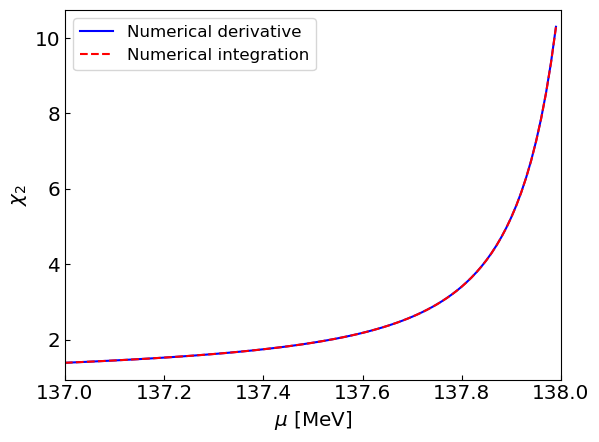

In [19]:
# Plot the results
import matplotlib.pyplot as plt

params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'xtick.direction':'in',
         'ytick.direction':'in',
         }
plt.rcParams.update(params)

plt.plot(mus, chi2sNder, label = "Numerical derivative", linestyle = '-', color = 'blue')
plt.plot(mus, chi2sNint, label = "Numerical integration", linestyle = '--', color = 'red')

plt.xlabel("${\mu}$ [MeV]")
plt.ylabel("${\\chi_2}$")
plt.xlim(mus[0],m)

plt.legend()

plt.show()

## BONUS: Using automatic differentiation

Let us use automatic differentiation to compute the susceptibility.
Here we will utilize MyGrad.

First, we define the density integrand in appropriate way for MyGrad

In [20]:
import mygrad as mg

def dfdx_mygrad(func, x):
    xx = mg.Tensor(x)
    y = func(xx)
    y.backward()
    return xx.grad

from mygrad import exp, sqrt

def fThermalMG(x):
    return d * x**2 * exp(x) / (2 * np.pi**2) / (exp(sqrt((m/T)**2 + x**2) - muAD/T) + eta)

We compute the susceptibility using automatic differentiation as a gradient of the density.

In [21]:
def chi2AD(inT, inMu, NGL = 32):
    global T, mu
    T = inT
    mu = inMu
    quad = laguerrexw32
    if (NGL != 32):
        quad = laguerrexw(NGL)

    def fAD(x):
        global muAD
        muAD = x
        return integrate_quadrature(fThermalMG, quad)
    
    return T * dfdx_mygrad(fAD, mu)

Let us perform the calculation and perform a comparison to other methods.

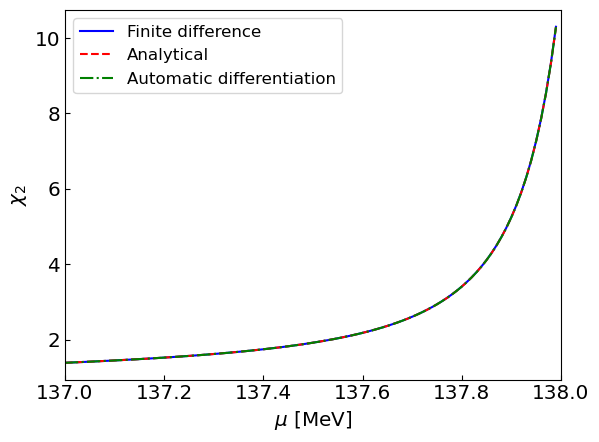

In [22]:
mus = np.arange(0., 138., 1.)
mus = np.arange(137., 138., 0.01)
# print(mus)
chi2sNder = []
chi2sNint = []
chi2sAD = []

dmu = 0.0001

for mu in mus:
    chi2sNder.append(chinumder(T, mu, dmu, NGL))
    chi2sNint.append(chiIntegral(T, mu, NGL))
    chi2sAD.append(chi2AD(T, mu, NGL))

plt.plot(mus, chi2sNder, label = "Finite difference", linestyle = '-', color = 'blue')
plt.plot(mus, chi2sNint, label = "Analytical", linestyle = '--', color = 'red')
plt.plot(mus, chi2sAD, label = "Automatic differentiation", linestyle = '-.', color = 'green')

plt.xlabel("${\mu}$ [MeV]")
plt.ylabel("${\\chi_2}$")
plt.xlim(mus[0],m)

plt.legend()

plt.show()